In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score,
    ConfusionMatrixDisplay, balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
plt.style.use('ggplot')
%matplotlib inline
sns.set_palette("pastel")


In [30]:
df = pd.read_csv('datas.csv') 

In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Verificar la variable objetivo
print("Valores únicos en la variable objetivo:")
print(df['Churn'].value_counts())
print(f"\nTipo de dato: {df['Churn'].dtype}")

# Opción 1A: Label Encoding (0 y 1)
df['Churn_encoded'] = LabelEncoder().fit_transform(df['Churn'])
print("\nDespués de Label Encoding:")
print(df['Churn_encoded'].value_counts())

# Opción 1B: Mapeo manual (más control)
df['Churn_encoded'] = df['Churn'].map({'No': 0, 'Yes': 1})
# O si tienes otros valores:
# df['Churn_encoded'] = df['Churn'].map({'No': 0, 'Yes': 1, 'Other': 2})

print("\nVerificación del mapeo:")
print(pd.crosstab(df['Churn'], df['Churn_encoded']))

def proporcion_columna(df, column):
    counts = df[column].value_counts()
    proportions = counts / len(df) * 100
    result = pd.DataFrame({'Count': counts, 'Proportion (%)': proportions})
    return result
proporcion_columna(df, 'Churn_encoded')

Valores únicos en la variable objetivo:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Tipo de dato: object

Después de Label Encoding:
Churn_encoded
0    5174
1    1869
Name: count, dtype: int64

Verificación del mapeo:
Churn_encoded     0     1
Churn                    
No             5174     0
Yes               0  1869


,Count,Proportion (%)
Churn_encoded,,
0,5174,73.463013
1,1869,26.536987


In [32]:
# =============================================================================
# CARGAR DATOS PREPROCESADOS DESDE EDA (Versión con diccionario)
# =============================================================================
import joblib

# Cargar el diccionario
data_dict = joblib.load("app/data_splits.joblib")

# Extraer cada conjunto de datos por su clave
X_train = data_dict["X_train"]
X_test = data_dict["X_test"]
y_train = data_dict["y_train"]
y_test = data_dict["y_test"]

print("✅ Datos cargados correctamente desde app/data_splits.joblib")
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


✅ Datos cargados correctamente desde app/data_splits.joblib
Shapes: (5634, 19) (1409, 19) (5634,) (1409,)


In [33]:
def clone_pipeline(pipeline):
    """
    Clona un pipeline de sklearn correctamente
    """
    from sklearn.pipeline import Pipeline
    from sklearn.base import clone
    
    if isinstance(pipeline, Pipeline):
        # Clonar cada paso del pipeline
        steps = []
        for name, step in pipeline.steps:
            steps.append((name, clone(step)))
        return Pipeline(steps)
    else:
        return clone(pipeline)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv_folds=5):
    """
    Evalúa un modelo y retorna métricas completas - VERSIÓN CORREGIDA
    """
    import time
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.model_selection import StratifiedKFold
    import numpy as np
    
    start_time = time.time()
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # AUC (solo si hay probabilidades)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation score - VERSIÓN SIMPLIFICADA Y SEGURA
    cv_scores = []
    try:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Clonar el pipeline completo
            model_clone = clone_pipeline(model)
            model_clone.fit(X_train_cv, y_train_cv)
            y_pred_cv = model_clone.predict(X_val_cv)
            cv_scores.append(f1_score(y_val_cv, y_pred_cv, average='macro', zero_division=0))
        
        cv_mean = np.mean(cv_scores)
    except Exception as e:
        print(f"⚠️  Error en CV para {model_name}: {e}")
        cv_mean = None
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'auc': auc_score,
        'cv_score': cv_mean,
        'train_time': train_time,
        'model_object': model
    }

In [34]:
# Identificar tipos de variables
numeric_features = []
categorical_features = []

for col in df.columns:
    if col not in ['customerID', 'Churn', 'Churn_encoded']:
        if df[col].dtype in ['int64', 'float64']:
            numeric_features.append(col)
        else:
            categorical_features.append(col)

print(f"\nCaracterísticas numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Características categóricas ({len(categorical_features)}): {categorical_features}")

# Variable objetivo
X = df[numeric_features + categorical_features]
y = df['Churn_encoded']

print(f"\nDistribución de clases:")
print(f"   Clase 0 (No Churn): {sum(y == 0)} muestras ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"   Clase 1 (Churn):    {sum(y == 1)} muestras ({sum(y == 1)/len(y)*100:.1f}%)")


Características numéricas (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Características categóricas (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']

Distribución de clases:
   Clase 0 (No Churn): 5174 muestras (73.5%)
   Clase 1 (Churn):    1869 muestras (26.5%)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nParticiones:")
print(f"   Training: {X_train.shape[0]} muestras")
print(f"   Test:     {X_test.shape[0]} muestras")

print(f"\nDistribución de clases en entrenamiento:")
print(f"   Clase 0 (No Churn): {sum(y_train == 0)} muestras ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   Clase 1 (Churn):    {sum(y_train == 1)} muestras ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

# =============================================================================
# PREPROCESADOR
# =============================================================================

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# =============================================================================
# LISTA PARA ALMACENAR RESULTADOS
# =============================================================================
results = []


Particiones:
   Training: 5634 muestras
   Test:     1409 muestras

Distribución de clases en entrenamiento:
   Clase 0 (No Churn): 4139 muestras (73.5%)
   Clase 1 (Churn):    1495 muestras (26.5%)


In [36]:
# =============================================================================
# 1. RANDOM FOREST
# =============================================================================
print("\n" + "="*50)
print("1. OPTIMIZACIÓN RANDOM FOREST")
print("="*50)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 15, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    rf_pipeline, rf_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Reducido para velocidad
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Entrenando Random Forest...")
rf_grid.fit(X_train, y_train)
print(f"Mejores parámetros: {rf_grid.best_params_}")
print(f"Mejor F1-score (CV): {rf_grid.best_score_:.4f}")

# Evaluación
result_rf = evaluate_model(rf_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                          "Random Forest", cv_folds=3)
results.append(result_rf)


1. OPTIMIZACIÓN RANDOM FOREST
Entrenando Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Mejor F1-score (CV): 0.7285


In [37]:
# =============================================================================
# 2. XGBOOST
# =============================================================================
print("\n" + "="*50)
print("2. OPTIMIZACIÓN XGBOOST")
print("="*50)

# Calcular scale_pos_weight SOLO con training data
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Scale pos weight calculado: {scale_pos_weight:.2f}")

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Entrenando XGBoost...")
xgb_grid.fit(X_train, y_train)
print(f"Mejores parámetros: {xgb_grid.best_params_}")
print(f"Mejor F1-score (CV): {xgb_grid.best_score_:.4f}")

# Evaluación
result_xgb = evaluate_model(xgb_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                           "XGBoost", cv_folds=3)
results.append(result_xgb)


2. OPTIMIZACIÓN XGBOOST
Scale pos weight calculado: 2.77
Entrenando XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0}
Mejor F1-score (CV): 0.7296


In [38]:
# =============================================================================
# 3. CATBOOST
# =============================================================================
print("\n" + "="*50)
print("3. OPTIMIZACIÓN CATBOOST")
print("="*50)

catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        random_state=42,
        verbose=0,
        auto_class_weights='Balanced'
    ))
])

catboost_params = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.05],
    'model__l2_leaf_reg': [1, 3]
}

catboost_grid = GridSearchCV(
    catboost_pipeline, catboost_params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Entrenando CatBoost...")
catboost_grid.fit(X_train, y_train)
print(f"Mejores parámetros: {catboost_grid.best_params_}")
print(f"Mejor F1-score (CV): {catboost_grid.best_score_:.4f}")

# Evaluación
result_catboost = evaluate_model(catboost_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                                "CatBoost", cv_folds=3)
results.append(result_catboost)


3. OPTIMIZACIÓN CATBOOST
Entrenando CatBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'model__depth': 6, 'model__iterations': 200, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.05}
Mejor F1-score (CV): 0.7285


In [39]:
# =============================================================================
# 4. LIGHTGBM
# =============================================================================
print("\n" + "="*50)
print("4. OPTIMIZACIÓN LIGHTGBM")
print("="*50)

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        class_weight='balanced'
    ))
])

lgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, -1],
    'model__learning_rate': [0.01, 0.1],
    'model__num_leaves': [31, 63],
    'model__subsample': [0.8, 1.0]
}

lgb_grid = GridSearchCV(
    lgb_pipeline, lgb_params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Entrenando LightGBM...")
lgb_grid.fit(X_train, y_train)
print(f"Mejores parámetros: {lgb_grid.best_params_}")
print(f"Mejor F1-score (CV): {lgb_grid.best_score_:.4f}")

# Evaluación
result_lgb = evaluate_model(lgb_grid.best_estimator_, X_train, X_test, y_train, y_test, 
                           "LightGBM", cv_folds=3)
results.append(result_lgb)


4. OPTIMIZACIÓN LIGHTGBM
Entrenando LightGBM...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100, 'model__num_leaves': 63, 'model__subsample': 0.8}
Mejor F1-score (CV): 0.7277



COMPARACIÓN FINAL DE LOS 4 MODELOS
           Model  Accuracy  Precision_Macro  Recall_Macro  F1_Macro     AUC  \
2       CatBoost    0.7537           0.7193        0.7726    0.7252  0.8462   
0  Random Forest    0.7779           0.7176        0.7293    0.7228  0.8264   
1        XGBoost    0.7587           0.7107        0.7504    0.7205  0.8317   
3       LightGBM    0.7537           0.7094        0.7530    0.7182  0.8341   

   Train_Time(s)  
2         9.1259  
0         3.9459  
1         7.4525  
3         0.6466  

🏆 MEJOR MODELO: CatBoost
   F1-Macro: 0.7252
   AUC: 0.8462
   Accuracy: 0.7537


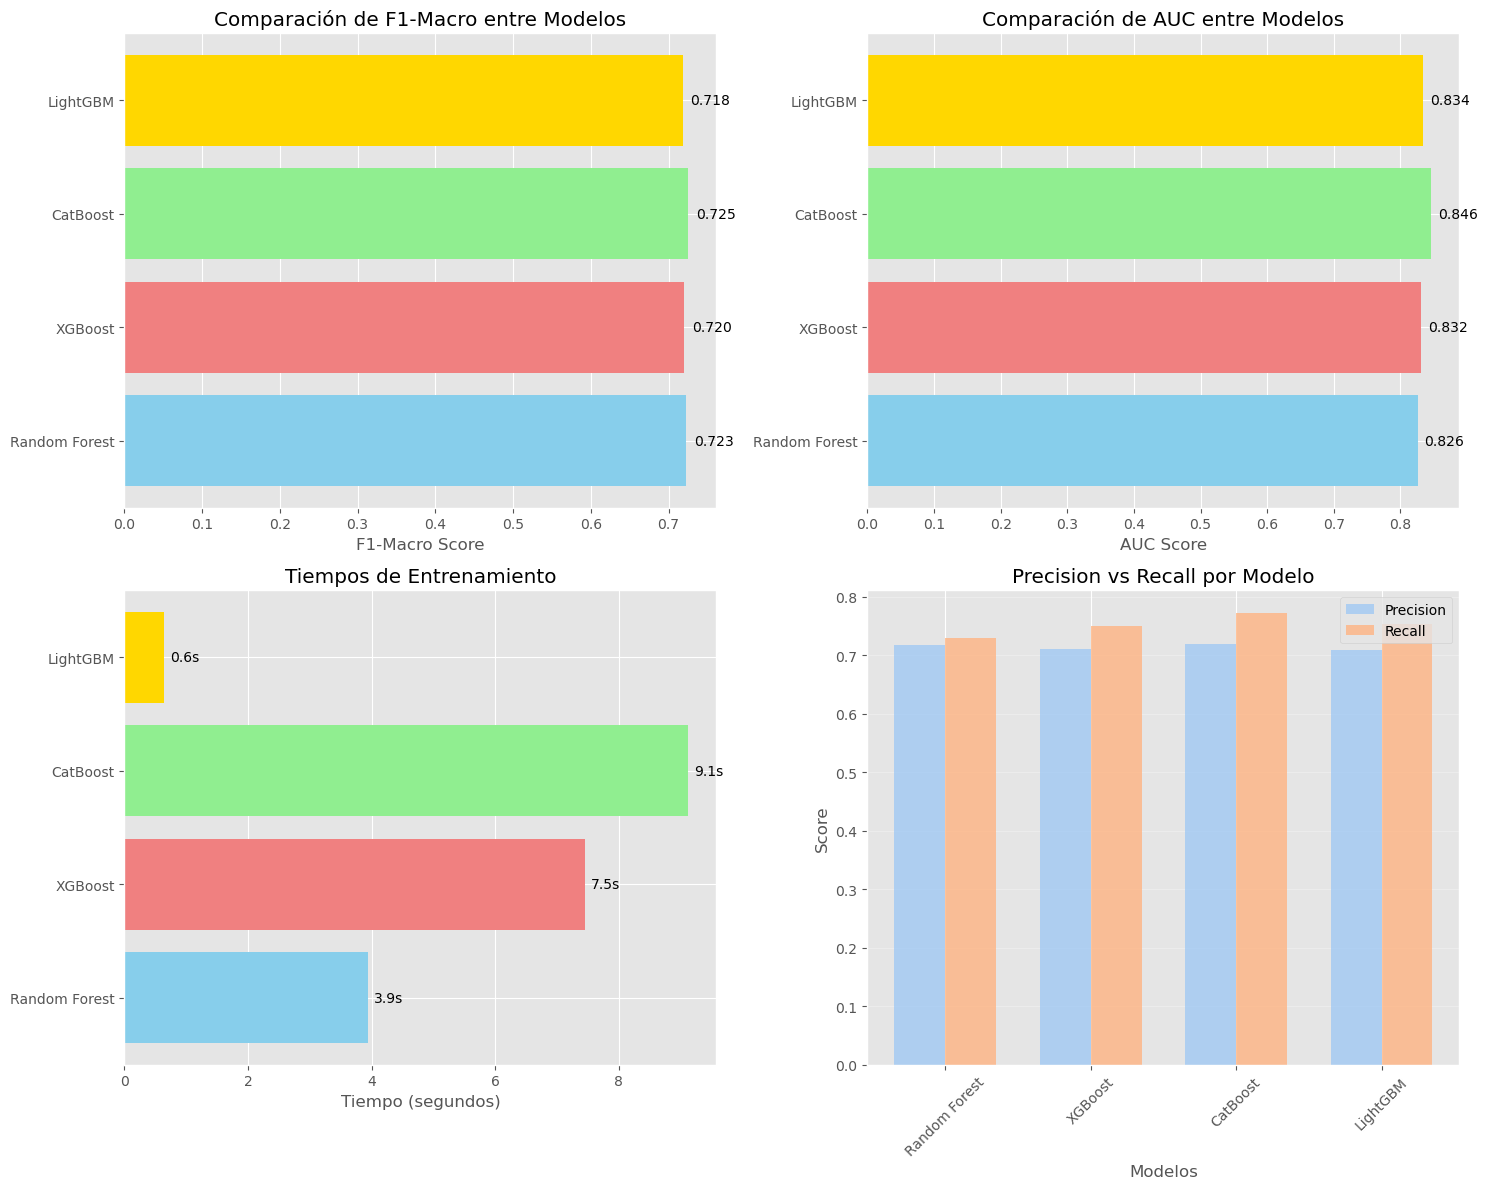


ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

Top 10 características más importantes:
                           feature  importance
1                           tenure   21.811678
35         Contract_Month-to-month   15.887054
15     InternetService_Fiber optic    7.449789
2                   MonthlyCharges    6.684214
37               Contract_Two year    4.501265
42  PaymentMethod_Electronic check    3.606105
17               OnlineSecurity_No    3.490303
26                  TechSupport_No    3.382866
36               Contract_One year    3.272296
38             PaperlessBilling_No    2.172783


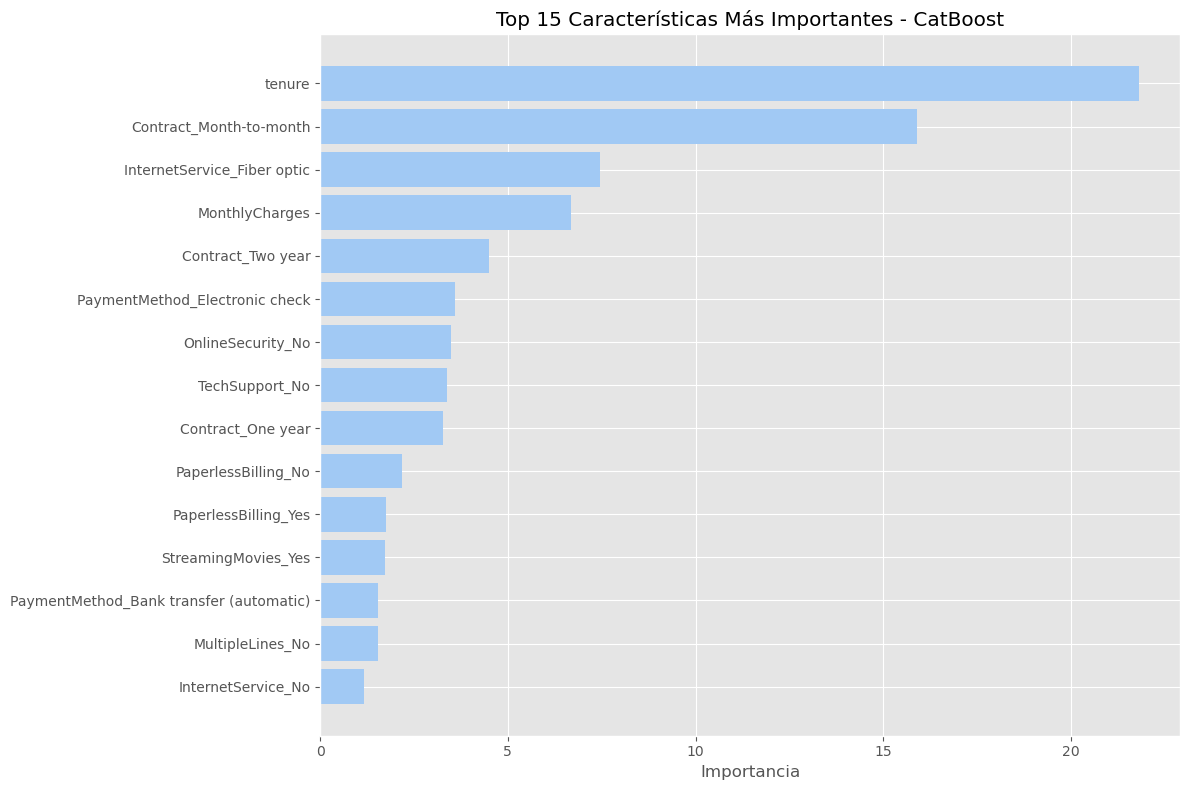


RESUMEN DEL PROYECTO DE PREDICCIÓN DE CHURN
📊 DATASET:
   - Total de muestras: 7043
   - Características: 3 numéricas, 16 categóricas
   - Distribución Churn: 1869 (26.5%)

🎯 RESULTADOS:
   - Mejor modelo: CatBoost
   - F1-Macro: 0.7252
   - AUC: 0.8462

⚙️  CONFIGURACIÓN:
   - Validación cruzada: 3 folds
   - Métrica principal: F1-Macro
   - Balance de clases: Implementado en todos los modelos

✅ PROYECTO COMPLETADO EXITOSAMENTE


In [40]:
# =============================================================================
# COMPARACIÓN FINAL DE MODELOS
# =============================================================================
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE LOS 4 MODELOS")
print("="*80)

# Crear DataFrame de resultados
results_df = pd.DataFrame([{
    'Model': r['model'],
    'Accuracy': r['accuracy'],
    'Precision_Macro': r['precision_macro'],
    'Recall_Macro': r['recall_macro'],
    'F1_Macro': r['f1_macro'],
    'AUC': r['auc'],
    'Train_Time(s)': r['train_time']
} for r in results])

# Ordenar por F1-Macro (métrica principal)
results_df = results_df.sort_values('F1_Macro', ascending=False)
print(results_df.round(4))

# Mostrar el mejor modelo
best_model = results_df.iloc[0]
print(f"\n🏆 MEJOR MODELO: {best_model['Model']}")
print(f"   F1-Macro: {best_model['F1_Macro']:.4f}")
print(f"   AUC: {best_model['AUC']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")

# =============================================================================
# VISUALIZACIÓN COMPARATIVA
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparación de F1-Scores
models = [r['model'] for r in results]
f1_scores = [r['f1_macro'] for r in results]

axes[0,0].barh(models, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[0,0].set_xlabel('F1-Macro Score')
axes[0,0].set_title('Comparación de F1-Macro entre Modelos')
for i, v in enumerate(f1_scores):
    axes[0,0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 2. Comparación de AUC
auc_scores = [r['auc'] for r in results]
axes[0,1].barh(models, auc_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[0,1].set_xlabel('AUC Score')
axes[0,1].set_title('Comparación de AUC entre Modelos')
for i, v in enumerate(auc_scores):
    axes[0,1].text(v + 0.01, i, f'{v:.3f}', va='center')

# 3. Tiempos de entrenamiento
times = [r['train_time'] for r in results]
axes[1,0].barh(models, times, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1,0].set_xlabel('Tiempo (segundos)')
axes[1,0].set_title('Tiempos de Entrenamiento')
for i, v in enumerate(times):
    axes[1,0].text(v + 0.1, i, f'{v:.1f}s', va='center')

# 4. Precision vs Recall
precision_scores = [r['precision_macro'] for r in results]
recall_scores = [r['recall_macro'] for r in results]
x = np.arange(len(models))
width = 0.35

axes[1,1].bar(x - width/2, precision_scores, width, label='Precision', alpha=0.8)
axes[1,1].bar(x + width/2, recall_scores, width, label='Recall', alpha=0.8)
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Precision vs Recall por Modelo')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models, rotation=45)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (MEJOR MODELO)
# =============================================================================
print("\n" + "="*80)
print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
print("="*80)

# Obtener el mejor modelo
best_result = results[results_df.index[0]]
best_model_obj = best_result['model_object']

# Obtener nombres de características después del preprocesamiento
if hasattr(best_model_obj, 'named_steps'):
    preprocessor = best_model_obj.named_steps['preprocessor']
    model = best_model_obj.named_steps['model']
    
    # Obtener nombres de características
    feature_names = []
    
    # Características numéricas
    feature_names.extend(numeric_features)
    
    # Características categóricas (después de OneHotEncoding)
    if hasattr(preprocessor, 'named_transformers_'):
        cat_transformer = preprocessor.named_transformers_['cat']
        if hasattr(cat_transformer, 'named_steps'):
            encoder = cat_transformer.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                cat_features = encoder.get_feature_names_out(categorical_features)
                feature_names.extend(cat_features)
    
    # Obtener importancia de características si está disponible
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Crear DataFrame de importancias
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(importances)],
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 características más importantes:")
        print(importance_df.head(10))
        
        # Visualizar top 15 características
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(top_features['feature'], top_features['importance'])
        plt.xlabel('Importancia')
        plt.title(f'Top 15 Características Más Importantes - {best_result["model"]}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*80)
print("RESUMEN DEL PROYECTO DE PREDICCIÓN DE CHURN")
print("="*80)

print(f"📊 DATASET:")
print(f"   - Total de muestras: {len(df)}")
print(f"   - Características: {len(numeric_features)} numéricas, {len(categorical_features)} categóricas")
print(f"   - Distribución Churn: {sum(y==1)} ({sum(y==1)/len(y)*100:.1f}%)")

print(f"\n🎯 RESULTADOS:")
print(f"   - Mejor modelo: {best_model['Model']}")
print(f"   - F1-Macro: {best_model['F1_Macro']:.4f}")
print(f"   - AUC: {best_model['AUC']:.4f}")

print(f"\n⚙️  CONFIGURACIÓN:")
print(f"   - Validación cruzada: 3 folds")
print(f"   - Métrica principal: F1-Macro")
print(f"   - Balance de clases: Implementado en todos los modelos")

print(f"\n✅ PROYECTO COMPLETADO EXITOSAMENTE")

In [41]:
# =============================================================================
# GUARDAR MODELO PARA PRODUCCIÓN
# =============================================================================
print("\n" + "="*80)
print("GUARDANDO MODELO PARA PRODUCCIÓN")
print("="*80)

import joblib
import os

# Crear carpeta app si no existe
os.makedirs('app', exist_ok=True)

try:
    # OPCIÓN A: Si tienes la variable 'results'
    best_model = results[0]['model_object']
    print("✅ Usando modelo de results[0]")

    # Buscar el mejor modelo por F1_macro
    if len(results) > 1:
        best_model_entry = max(results, key=lambda x: x['f1_macro'])
        best_model = best_model_entry['model_object']
        print(f"🏆 Mejor modelo: {best_model_entry['model']} (F1: {best_model_entry['f1_macro']:.4f})")

except NameError:
    try:
        # OPCIÓN B: Si tienes GridSearch
        best_model = rf_grid.best_estimator_
        print("✅ Usando modelo de rf_grid")
    except NameError:
        print("❌ No se encontró el modelo. Verifica tu variable.")
        print("Variables disponibles:", [x for x in dir() if not x.startswith('_')])

# Guardar como .joblib
joblib.dump(best_model, 'app/model.joblib')
print("✅ Modelo guardado en: app/model.joblib")

# =============================================================================
# VERIFICACIÓN DEL MODELO GUARDADO
# =============================================================================
try:
    loaded_model = joblib.load('app/model.joblib')
    print("✅ Modelo se puede cargar correctamente")
    
    # Prueba de predicción
    try:
        test_pred = loaded_model.predict(X_test.iloc[:1])
        print(f"✅ Predicción de prueba exitosa: {test_pred[0]}")
    except NameError:
        print("ℹ️ X_test no disponible - omitiendo prueba de predicción")
except Exception as e:
    print(f"❌ Error cargando modelo: {e}")



GUARDANDO MODELO PARA PRODUCCIÓN
✅ Usando modelo de results[0]
🏆 Mejor modelo: CatBoost (F1: 0.7252)
✅ Modelo guardado en: app/model.joblib
✅ Modelo se puede cargar correctamente
✅ Predicción de prueba exitosa: 0
